## Statistical arbitrage

This work attempts to evaluate whether or not it is possible to generate profit from statistical arbitrage applied to cryptocurrencies. The approach is to apply pairs trading and evaluate points to buy or sell a specific cryptocurrency. Pairs trading consists of:

```LatEx
I) Identifying a pair of stocks that move similarly and possess mean-reverting properties 

II) Sell the high priced stock and buy the low priced stock
```

The strategy shown here focuses on cointegration as the core strategy for pairs trading. We show that Litecoin (LTC) and Stellar (XLM) seem to have mean-reverting properties and therefore could be used to perform arbitrage.

### Import libs

In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from utility_functions import *

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Setup

In [4]:
n_years = 1
n_days = int(365 * n_years)
print(n_days)

365


### Load data

#### Parameters

In [5]:
tickers = ['XLM-USD', 'LTC-USD', 'BTC-USD']

#### Select stocks

In [6]:
assets = {}

for ticker in tickers:
    print(f'Gathering data for {ticker} for the past {n_years} years')
    data = (
        yf.download(
            tickers=ticker,
            start=dt.date.today() - dt.timedelta(n_days),
            end=dt.datetime.today()
        )
    )    
    assets[ticker] = data

Gathering data for XLM-USD for the past 1 years
[*********************100%***********************]  1 of 1 completed
Gathering data for LTC-USD for the past 1 years
[*********************100%***********************]  1 of 1 completed
Gathering data for BTC-USD for the past 1 years
[*********************100%***********************]  1 of 1 completed


#### Format columns

In [7]:
for key in assets.keys(): 
    print(f'Fixing data for {key}')
    assets[key].reset_index(inplace=True)
    assets[key]['Date'] = (
        assets[key]['Date']
        .apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
    )

Fixing data for XLM-USD
Fixing data for LTC-USD
Fixing data for BTC-USD


### Analyze cointegrated pairs

#### Stock Market evolution

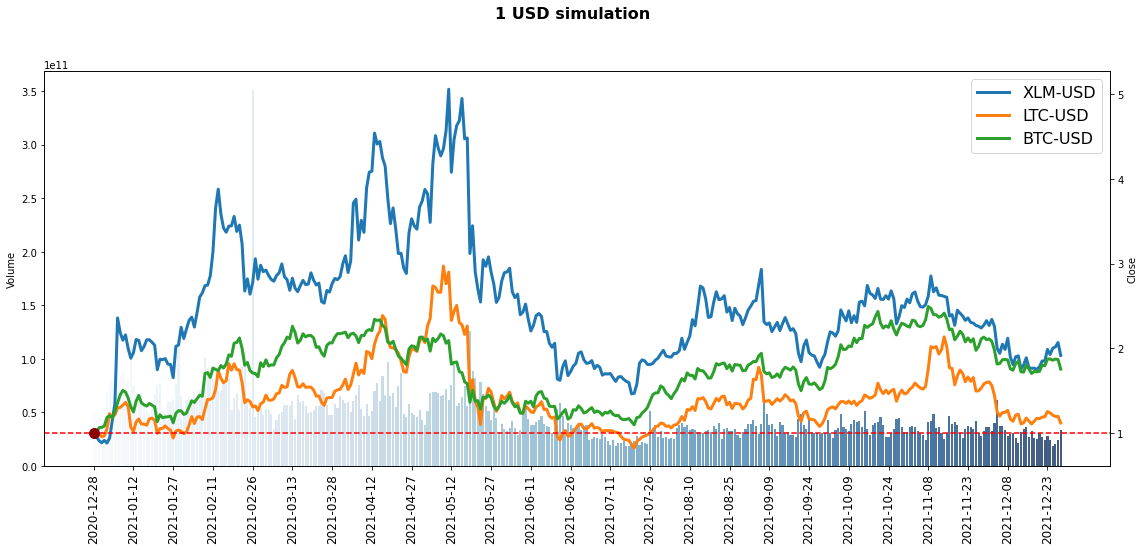

In [8]:
fig, ax_ = plt.subplots(1, 1, figsize=(16, 8))

ax = ax_.twinx()

ref_tick = tickers[-1]
x_ = assets[ref_tick].index
dates = assets[ref_tick]['Date']
volume = assets[ref_tick]['Volume']

for tick in tickers:
    y_ = assets[tick]['Close']
    y_norm = y_/y_[0]
    sns.lineplot(x_, y_norm, ax=ax, label=f'{tick}', lw=3.0)
    
nulls = mask_idx(x_, m=15)
sns.barplot(x_, volume, ax=ax_, palette='Blues', alpha=0.8)
ax_.set_xticks(x_[nulls])
ax_.set_xticklabels(dates[nulls], rotation=90, fontsize=12)
ax.axhline(1, linestyle='--', color='red')
ax.plot([0], [1], 'o', color='darkred', ms=10.0)
ax.legend(fontsize=16)
fig.suptitle(f'1 USD simulation', fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Cointegrated pairs

In [9]:
from statistical_arbitrage import Cointegrate
a, b = tickers[0], tickers[1]
x = assets[a]['Close']
y = assets[b]['Close']
coint = Cointegrate(x, y)

In [10]:
coint.regression()

Intercept: 38.77330117809487
Coefficient: 405.5300026353451
ADF Statistic: -4.0015412351369815
p-value: 0.0014024623610258094


#### Setup parameters

In [11]:
signals = coint.signals
y_pred = coint.y_pred
residuals = coint.residuals
ub, lb = coint.ub, coint.lb

keys = list(assets.keys())
key = keys[0]
dates = assets[key]['Date']
x_ = assets[key].index

### Visualize

Text(0.5, 0.98, 'Statistical Arbitrage')

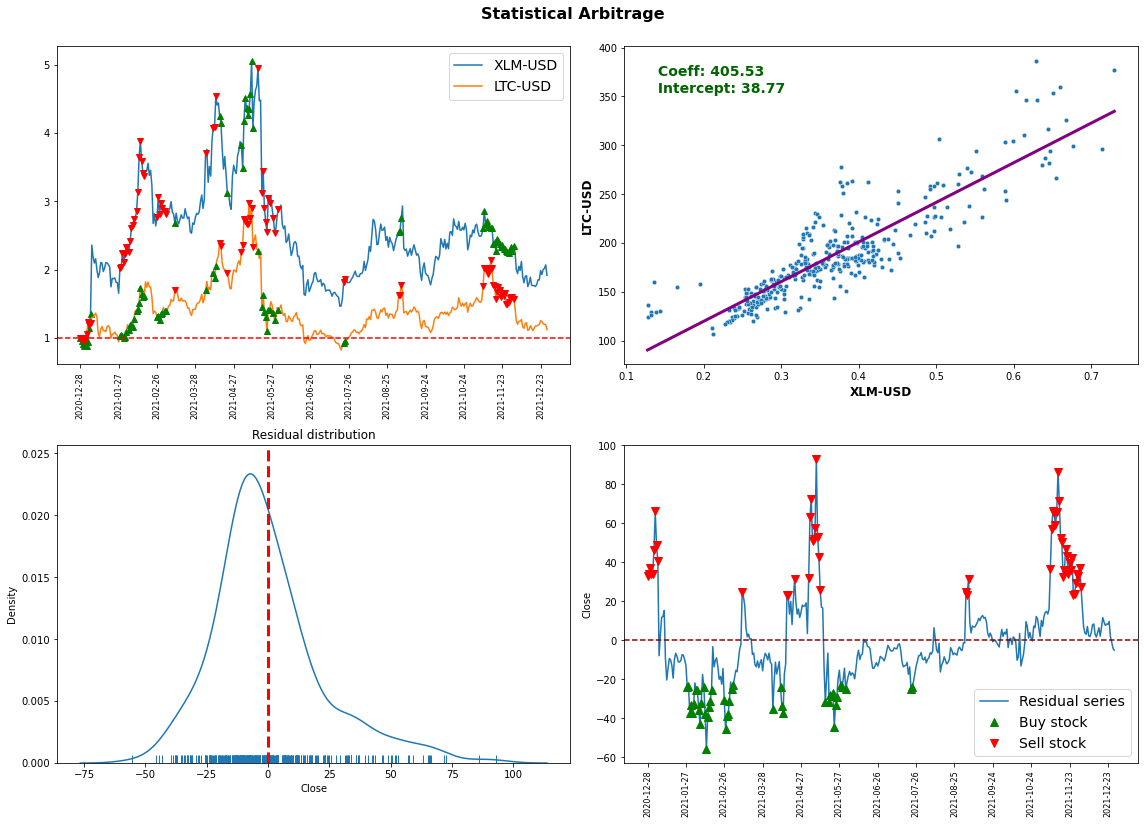

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.ravel()

nulls = mask_idx(x_, m=30)

for j, key in enumerate([a, b]):
    y_ = assets[key]['Close']
    ax[0].plot(x_, y_/y_[0], label=key)
    for i, marker, color in [(-1, '^', 'g'), (1, 'v', 'r')]:
        m = -2 * j + 1    
        ax[0].plot(x_[signals == i * m],
                y_[signals == i * m]/y_[0],
                marker=marker,
                lw=0,
                markersize=6,
                c=color)
        ax[0].legend(fontsize=14)
        
ax[0].set_xticks(x_[nulls])
ax[0].set_xticklabels(dates[nulls], rotation=90, fontsize=8)
ax[0].axhline(1, linestyle='--', color='red')

sns.scatterplot(x=x, y=y, ax=ax[1], s=20)
sns.lineplot(x=x, y=y_pred, ax=ax[1], color='purple', lw=3.0)
cx = np.percentile(x, q=1)
cy = np.percentile(y, q=99)
intercept = coint.reg.intercept_
coef = coint.reg.coef_[0]
ax[1].annotate(f'\n Coeff: {round(coef,2)} \n '+
               f'Intercept: {round(intercept,2)}',
               xy=(cx, cy), 
               color='darkgreen',
               weight='bold',
               fontsize=14)

ax[1].set_xlabel(a, fontsize=12, weight='bold')
ax[1].set_ylabel(b, fontsize=12, weight='bold')

sns.distplot(
    a=residuals,
    hist=False, kde=True, rug=True, 
    ax=ax[2])

ax[2].axvline(0, linestyle='--', color='red', lw=3.0)
ax[2].set_title('Residual distribution')

sns.lineplot(
    x=x_,
    y=residuals,
    ax=ax[3],
    label=f'Residual Series')

for i, marker, color in [(1, '^', 'g'), (-1, 'v', 'r')]:
    ax[3].plot(
        x_[signals == i],
        residuals[signals == i],
        marker=marker,
        lw=0,
        markersize=8,
        c=color)
    
ax[3].legend(['Residual series','Buy stock','Sell stock'],fontsize=14)    
ax[3].set_xticks(x_[nulls])
ax[3].set_xticklabels(dates[nulls], rotation=90, fontsize=8)
ax[3].axhline(0, linestyle='--', color='darkred')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Statistical Arbitrage', fontsize=16, weight='bold')